In [1]:
import math
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class value:
    def __init__(self, data, _children=(),sign='', label=""):
        self._prev = set(_children)
        self.data = data
        self.grad = 0.0
        self.sign = sign
        self.label = label
        self._backward = lambda: None
        self.traveled = []
    
    def __repr__(self):
        return f"value(data = {self.data}, grad is {self.grad}, sign is {self.sign}, label is {self.label})"
    def __add__(self, other):
        other = value(other) if not isinstance(other, value) else other
        out = value(self.data + other.data, (self,other),"+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __radd__(self, other):
        return self + (other)
    def relu(self):
        out = value(0 if self.data < 0 else self.data)

        def _backward():
            self.grad = (out.data > 0) * out.grad
        
        out._backward = _backward 
        return out
    def __mul__(self, other):
        other = value(other) if not isinstance(other, value) else other
        out = value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out 
    def __rmul__(self,other):
        return self * (other)
    
    def __pow__(self, x):
        self
        assert isinstance(x, (int, float)) 
        # x = value(x) if not isinstance(x, value) else x
        out = value(self.data ** x,(self,),"**")
        def _backward():
            # self.grad += x.data * self.data ** (x.data - 1.0) * out.grad
            self.grad += (x * (self.data ** (x - 1) ))* out.grad
        out._backward = _backward 
         

        return out
    
    def exp(self):
        x = self.data
        out = value(math.exp(x),(self,),"exp")
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
     
    def __sub__(self, other):
        out = self + (-other)

        return out
    
    def __truediv__(self, other):
        other = value(other) if not isinstance(other, value) else other
        out = self * (other**-1)
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2.0 * n) - 1.0 )/(math.exp(2.0 * n) + 1.0)
        out = value(t,(self,),sign="tanh", label=self.label)
        def _backward():
            self.grad += (1.0 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backprop(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(x):
            if x not in visited:
                visited.add(x)
                for child in x._prev:
                    build_topo(child)
                topo.append(x)
        build_topo(self)

        for node in reversed(topo):
            # return None
            node._backward()

In [3]:
from graphviz import Digraph

def trace(x):
    nodes, edges = set(), set()
    def build(x):
        if x not in nodes:
            nodes.add(x)
            for child in x._prev:
                edges.add((child, x))
                build(child)
    build(x)
    return nodes, edges


def draw(number):
    dot = Digraph(format="svg",graph_attr={'rankdir':'LR'})

    nodes, edges = trace(number)
    for i in nodes:
        uid = str(id(i))

        dot.node(uid, label="{ %s | data %.4f | grad %.4f}" % (i.label, i.data,i.grad), shape="record")

        if i.sign:
            dot.node(name=f"{uid+i.sign}",label=f"{i.sign}")

            dot.edge(uid+i.sign, uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2.sign)  
    
    return dot
# draw(l)

In [4]:
x1 = value(2.0, label="x1")
x2 = value(0.0, label="x2")

w1 = value(-3.0, label="w1")
w2 = value(1.0, label="w2")

bias = value(6.8813, label="bias")

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + bias; n.label = 'n'
e = (2*n).exp()
o =  (e - 1) / (e + 1); o.label = 'o'


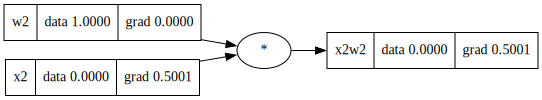

In [5]:
o.backprop()
draw(x2w2)


In [6]:
#  x = torch.rand(5,3)
# print(x)
# x1 = torch.tensor([2.0]); x1.requires_grad = True
# x2 = torch.tensor([0.0]); x2.requires_grad = True
# w1 = torch.tensor([-3.0]); w1.requires_grad = True
# w2 = torch.tensor([1.0]); w2.requires_grad = True

# bias = torch.tensor([6.8813]); bias.requires_grad = True

# x1w1 = x1 * w1
# x2w2 = x2 * w2
# x1w1x2w2 = x1w1 + x2w2
# n = x1w1x2w2 + bias
# o = torch.tanh(n)


# print(o.data.item())
# o.backward()

# # print(o.grad.item())
# print(x1.grad.item(), x2.grad.item(), w1.grad.item(), w2.grad.item(), bias.grad.item())


In [7]:
class neuron:
    def __init__(self,nin):
        self.w = [value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = value(random.uniform(-1,1))
    
    def __call__(self,x):
        act =  sum((wi * xi for wi,xi in zip(self.w,x)),start=self.b)  

        out = act.tanh()

        return out

    def parameters(self,):
        return self.w + [self.b]  
    
class layer:
    def __init__(self, nin,nout):
        self.neurons = [neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [y for neuron in self.neurons for y in neuron.parameters()]

class MLP:
    def __init__(self,nins,nouts):
        size = [nins] + nouts
        self.layers = [layer(size[i],size[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for f in self.layers:
            x = f(x)    
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] 
    

# plt.plot()

In [8]:
frik = MLP(3,[4,4,1])

In [9]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0,1.0,-1.0]
]

ys = [1.0, -1.0,-1.0, 1.0]

# draw(y[0])
# print(y)



# frik.parameters()

In [10]:
y = [frik(x) for x in xs]
loss = sum((pred - goal)**2 for pred, goal in zip(y,ys))
loss

value(data = 3.5797527130710085, grad is 0.0, sign is +, label is )

In [11]:


delta = sum((pred - goal) for pred, goal in zip(y, ys))

loss

value(data = 3.5797527130710085, grad is 0.0, sign is +, label is )

In [12]:
loss.backprop()

In [13]:
for p in frik.parameters():
    p.data += -0.01 * p.grad

In [ ]:
for k in range(100):
    y = [frik(x) for x in xs]
    loss = sum((pred - goal)**2 for pred, goal in zip(y,ys))

    for p in frik.parameters():
        p.grad = 0.0
    loss.backprop()

    for p in frik.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data, y)
